# Analyzing the relation between home matches and match wins in the English Premier League (Soccer)

### Vikam Sehgal

### Introduction
Test: https://www.researchgate.net/publication/261402166_Calculating_the_Home_Advantage_in_Soccer_Leagues#:~:text=Home%2Dadvantage%20describes%20the%20benefit,%2C%202014)%20.%20...

Data: https://datahub.io/sports-data/english-premier-league

blah blah blah blahblah blah
With the premier league in full swing, discussion about home field advantage is in full swing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_set_18_19 = pd.read_csv('18_19_data.csv')
data_set_18_19.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


### Loading Data, Transforming, and Tidying
We will now transform, load, and tidy our data so as to be able to run desired operations on it.
Our dataset unfortunately doesn't provide us with an end of season table.
With the given information we can construct our own end of season table. 
We information regarding the matches - what team was the home team, what team was the away team, did the home team win or did the away team win. This is all the questions we need answered to be able to construct our table.

### Steps:
I first create a list of all the teams that are mentioned in the dataset. I iterate over all the matches held in the season and add both the home team and the away team to the "teams" list. Since each team has had multiple matches the list will contain duplicates. We can simply transform the list to a set and then back to a list to be able to store it in our end of season table dataframe.
I then create a dictionary, that stores the team name as the key and a match stat list as their value, with each index corresponding to either a win, loss, draw, home win, home goals scored, home goals conceded.
I then loop over this dictionary and add the stats to our data set.
To add points the english premier league follows a simple princple. For every match won the winning team gets 3 points, every match lost gives the team 0 points, every match that ended as a draw gives both the teams 1 point.

In [3]:
# group by teams to create columns of team, wins, loss, home wins, home goals scored, home goals conceded
def data_to_df(data_set):
    teams = []
    team_stat = {}
    for i in data_set.iterrows():
        teams.append(i[1].HomeTeam)
        teams.append(i[1].AwayTeam)
    #remove duplicates from teams
    teams = set(teams)
    for i in teams:
        team_stat[i] = [0,0,0,0,0,0,0]
    for i in data_set.iterrows():
        team_stat[i[1].HomeTeam][0]+=1
        team_stat[i[1].AwayTeam][0]+=1
        team_stat[i[1].HomeTeam][5]+=i[1].FTHG
        team_stat[i[1].HomeTeam][6]+=i[1].FTAG
        if i[1].FTHG > i[1].FTAG:
            team_stat[i[1].HomeTeam][1]+=1
            team_stat[i[1].HomeTeam][4]+=1
            team_stat[i[1].AwayTeam][2]+=1
        elif i[1].FTHG < i[1].FTAG:
            team_stat[i[1].AwayTeam][1]+=1
            team_stat[i[1].HomeTeam][2]+=1
        else:
            team_stat[i[1].HomeTeam][3]+=1
            team_stat[i[1].AwayTeam][3]+=1
    # print(team_stat)
    mp, wins, loss, draw, hw, hgs, hgc = [],[],[],[],[], [], []
    for v in team_stat:
        mp.append(team_stat[v][0])
        wins.append(team_stat[v][1])
        loss.append(team_stat[v][2])
        draw.append(team_stat[v][3])
        hw.append(team_stat[v][4])
        hgs.append(team_stat[v][5])
        hgc.append(team_stat[v][6])
    points = []
    #calculate points
    for i in range(0,len(mp)):
        points.append(wins[i]*3 + draw[i])
    epl_table = pd.DataFrame(data={'team': list(teams), 'matches_played': mp,
                                   'wins':wins, 'loss':loss,
                                   'draw':draw, 'home_win': hw,
                                  'points': points, 'home_goals': hgs,
                                  'home_goals_conceded': hgc})
    return epl_table
epl_table = data_to_df(data_set_18_19)
epl_points = epl_table.sort_values(by=['points'], ascending=False)
epl_home_games = epl_table.sort_values(by=['home_win'], ascending=False)

## Add PL TABLE 18-19  Image - Naman
# P.S. - Should we arrange data from most to recent to oldest or the other way? Tell me I will sort it out while adding these images.

In [4]:
# End of season table sorted by points.
epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
19,Man City,38,32,4,2,18,98,57,12
10,Liverpool,38,30,1,7,17,97,55,10
0,Chelsea,38,21,8,9,12,72,39,12
8,Tottenham,38,23,13,2,12,71,34,16
2,Arsenal,38,21,10,7,14,70,42,16
5,Man United,38,19,10,9,10,66,33,25
4,Wolves,38,16,13,9,10,57,28,21
15,Everton,38,15,14,9,10,54,30,21
3,Leicester,38,15,16,7,8,52,24,20
16,West Ham,38,15,16,7,9,52,32,27


In [5]:
# End of season table sorted by the number of home games won
epl_home_games

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
19,Man City,38,32,4,2,18,98,57,12
10,Liverpool,38,30,1,7,17,97,55,10
2,Arsenal,38,21,10,7,14,70,42,16
8,Tottenham,38,23,13,2,12,71,34,16
0,Chelsea,38,21,8,9,12,72,39,12
5,Man United,38,19,10,9,10,66,33,25
4,Wolves,38,16,13,9,10,57,28,21
15,Everton,38,15,14,9,10,54,30,21
16,West Ham,38,15,16,7,9,52,32,27
6,Newcastle,38,12,17,9,8,45,24,25


### Adding Stats
Now that we have our single season table, we will add some new features
We will calculate the following:
 1. Home Win % = home_win / home matches_played (19)
 2. Total Win % = wins / matches_played

In [6]:
epl_points['home_win%'] = epl_points['home_win']/19
epl_points['total_win%'] = epl_points['wins']/epl_points['matches_played']
epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
19,Man City,38,32,4,2,18,98,57,12,0.947368,0.842105
10,Liverpool,38,30,1,7,17,97,55,10,0.894737,0.789474
0,Chelsea,38,21,8,9,12,72,39,12,0.631579,0.552632
8,Tottenham,38,23,13,2,12,71,34,16,0.631579,0.605263
2,Arsenal,38,21,10,7,14,70,42,16,0.736842,0.552632
5,Man United,38,19,10,9,10,66,33,25,0.526316,0.500000
4,Wolves,38,16,13,9,10,57,28,21,0.526316,0.421053
15,Everton,38,15,14,9,10,54,30,21,0.526316,0.394737
3,Leicester,38,15,16,7,8,52,24,20,0.421053,0.394737
16,West Ham,38,15,16,7,9,52,32,27,0.473684,0.394737


To get an idea of what advantage a home game gives we add the 'home_advantage' feature.
Home advantage in the english premier league is calculated as follows:
 Home Advantage = (Home Goals Scored - Home Goals Conceded) / 19

source: https://www.pinnacle.com/en/betting-articles/Soccer/Home-Field-Advantage/FGU2ZXMPGZCTFHSE

In [7]:
epl_points['home_advantage'] = (epl_points['home_goals'] - epl_points['home_goals_conceded']) /19
epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
19,Man City,38,32,4,2,18,98,57,12,0.947368,0.842105,2.368421
10,Liverpool,38,30,1,7,17,97,55,10,0.894737,0.789474,2.368421
0,Chelsea,38,21,8,9,12,72,39,12,0.631579,0.552632,1.421053
8,Tottenham,38,23,13,2,12,71,34,16,0.631579,0.605263,0.947368
2,Arsenal,38,21,10,7,14,70,42,16,0.736842,0.552632,1.368421
5,Man United,38,19,10,9,10,66,33,25,0.526316,0.500000,0.421053
4,Wolves,38,16,13,9,10,57,28,21,0.526316,0.421053,0.368421
15,Everton,38,15,14,9,10,54,30,21,0.526316,0.394737,0.473684
3,Leicester,38,15,16,7,8,52,24,20,0.421053,0.394737,0.210526
16,West Ham,38,15,16,7,9,52,32,27,0.473684,0.394737,0.263158


### Plot for season 18-19
We now visualize the home advantage and the home_win% by plotting scatter plots.
Here the x axis is the team, and y axis is the home advantage and home_win%.

These plots give us a rough visual idea of the home advantage and home_win% over the season.

<AxesSubplot:title={'center':'Team Advantage of each team Season 18-19'}, xlabel='team', ylabel='home_advantage'>

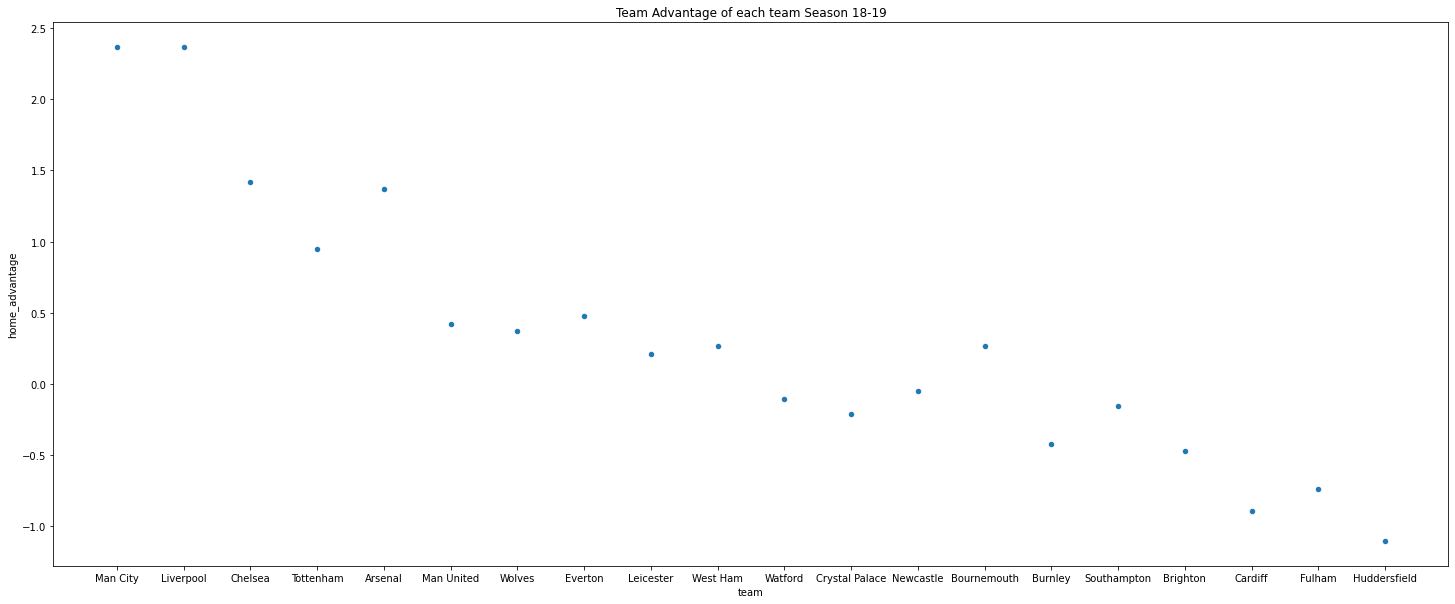

In [8]:
epl_points.plot(x='team', y='home_advantage', kind='scatter', 
                    title = 'Team Advantage of each team Season 18-19',
               figsize=(25,10))

<AxesSubplot:title={'center':'Home wins over all wins in 18-19'}, xlabel='team', ylabel='home_win%'>

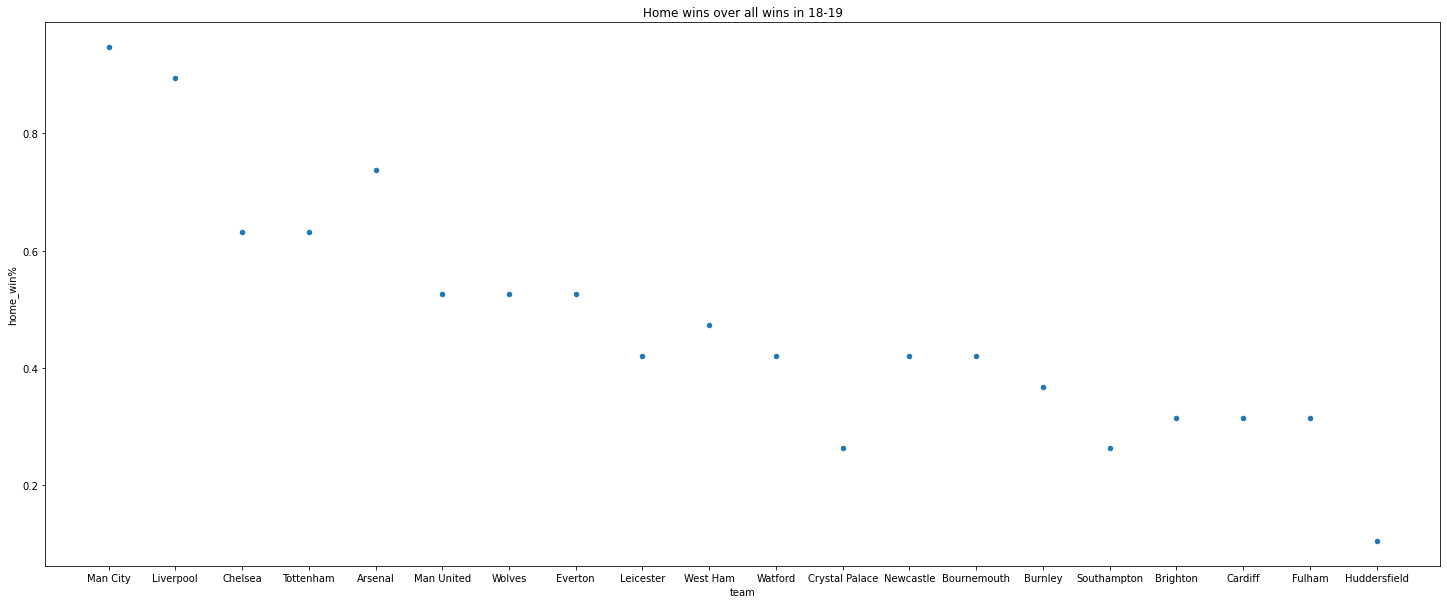

In [9]:
epl_points.plot(x='team', y='home_win%', kind='scatter', 
                    title = 'Home wins over all wins in 18-19',
               figsize=(25,10))

### MERGING HOME WINS TABLE AND POINTS TABLE BY TEAM FOR SEASON 18-19 -> ASHRAY 

In [10]:
combined_table1819 = pd.merge(epl_home_games,epl_points, how='inner', on=['team'])
combined_table1819['year'] = 2018
combined_table1819

,team,matches_played_x,wins_x,loss_x,draw_x,home_win_x,points_x,home_goals_x,home_goals_conceded_x,matches_played_y,...,loss_y,draw_y,home_win_y,points_y,home_goals_y,home_goals_conceded_y,home_win%,total_win%,home_advantage,year
0,Man City,38,32,4,2,18,98,57,12,38,...,4,2,18,98,57,12,0.947368,0.842105,2.368421,2018
1,Liverpool,38,30,1,7,17,97,55,10,38,...,1,7,17,97,55,10,0.894737,0.789474,2.368421,2018
2,Arsenal,38,21,10,7,14,70,42,16,38,...,10,7,14,70,42,16,0.736842,0.552632,1.368421,2018
3,Tottenham,38,23,13,2,12,71,34,16,38,...,13,2,12,71,34,16,0.631579,0.605263,0.947368,2018
4,Chelsea,38,21,8,9,12,72,39,12,38,...,8,9,12,72,39,12,0.631579,0.552632,1.421053,2018
5,Man United,38,19,10,9,10,66,33,25,38,...,10,9,10,66,33,25,0.526316,0.500000,0.421053,2018
6,Wolves,38,16,13,9,10,57,28,21,38,...,13,9,10,57,28,21,0.526316,0.421053,0.368421,2018
7,Everton,38,15,14,9,10,54,30,21,38,...,14,9,10,54,30,21,0.526316,0.394737,0.473684,2018
8,West Ham,38,15,16,7,9,52,32,27,38,...,16,7,9,52,32,27,0.473684,0.394737,0.263158,2018
9,Newcastle,38,12,17,9,8,45,24,25,38,...,17,9,8,45,24,25,0.421053,0.315789,-0.052632,2018


### Observation:
some observation here.....

Let us look at the data from past 5 seasons to get a better idea

In [11]:
# Load data from other 4 seasons: 14-15, 15-16, 16-17, 17-18
epl_table1415 = data_to_df(pd.read_csv('14_15_data.csv'))
epl_table1516 = data_to_df(pd.read_csv('15_16_data.csv'))
epl_table1617 = data_to_df(pd.read_csv('16_17_data.csv'))
epl_table1718 = data_to_df(pd.read_csv('17_18_data.csv'))

## Naman

In [12]:
epl_table1819 = epl_points

In [13]:
epl_table1819

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
19,Man City,38,32,4,2,18,98,57,12,0.947368,0.842105,2.368421
10,Liverpool,38,30,1,7,17,97,55,10,0.894737,0.789474,2.368421
0,Chelsea,38,21,8,9,12,72,39,12,0.631579,0.552632,1.421053
8,Tottenham,38,23,13,2,12,71,34,16,0.631579,0.605263,0.947368
2,Arsenal,38,21,10,7,14,70,42,16,0.736842,0.552632,1.368421
5,Man United,38,19,10,9,10,66,33,25,0.526316,0.500000,0.421053
4,Wolves,38,16,13,9,10,57,28,21,0.526316,0.421053,0.368421
15,Everton,38,15,14,9,10,54,30,21,0.526316,0.394737,0.473684
3,Leicester,38,15,16,7,8,52,24,20,0.421053,0.394737,0.210526
16,West Ham,38,15,16,7,9,52,32,27,0.473684,0.394737,0.263158


In [14]:
epl_table1718

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
0,Chelsea,38,21,10,7,11,70,30,16
1,Bournemouth,38,11,16,11,7,44,26,30
2,Arsenal,38,19,13,6,15,63,54,20
3,Leicester,38,12,15,11,7,47,25,22
4,Man United,38,25,7,6,15,81,38,9
5,Watford,38,11,19,8,7,41,27,31
6,Newcastle,38,12,18,8,8,44,21,17
7,Tottenham,38,23,7,8,13,77,40,16
8,Burnley,38,14,12,12,7,54,16,17
9,Liverpool,38,21,5,12,12,75,45,10


In [15]:
epl_points1718 = epl_table1718.sort_values(by=['points'], ascending=False)

## ADD PL TABLE 17-18 IMAGE - NAMAN

In [16]:
epl_points1718

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
19,Man City,38,32,2,4,16,100,61,14
4,Man United,38,25,7,6,15,81,38,9
7,Tottenham,38,23,7,8,13,77,40,16
9,Liverpool,38,21,5,12,12,75,45,10
0,Chelsea,38,21,10,7,11,70,30,16
2,Arsenal,38,19,13,6,15,63,54,20
8,Burnley,38,14,12,12,7,54,16,17
14,Everton,38,13,15,10,10,49,28,22
3,Leicester,38,12,15,11,7,47,25,22
6,Newcastle,38,12,18,8,8,44,21,17


In [17]:
epl_home_games1718 = epl_table1718.sort_values(by=['home_win'], ascending=False)

In [18]:
epl_home_games1718

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
19,Man City,38,32,2,4,16,100,61,14
2,Arsenal,38,19,13,6,15,63,54,20
4,Man United,38,25,7,6,15,81,38,9
7,Tottenham,38,23,7,8,13,77,40,16
9,Liverpool,38,21,5,12,12,75,45,10
0,Chelsea,38,21,10,7,11,70,30,16
14,Everton,38,13,15,10,10,49,28,22
6,Newcastle,38,12,18,8,8,44,21,17
5,Watford,38,11,19,8,7,41,27,31
8,Burnley,38,14,12,12,7,54,16,17


In [19]:
epl_points1718['home_win%'] = epl_points1718['home_win']/19
epl_points1718['total_win%'] = epl_points1718['wins']/epl_points1718['matches_played']
epl_points1718

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
19,Man City,38,32,2,4,16,100,61,14,0.842105,0.842105
4,Man United,38,25,7,6,15,81,38,9,0.789474,0.657895
7,Tottenham,38,23,7,8,13,77,40,16,0.684211,0.605263
9,Liverpool,38,21,5,12,12,75,45,10,0.631579,0.552632
0,Chelsea,38,21,10,7,11,70,30,16,0.578947,0.552632
2,Arsenal,38,19,13,6,15,63,54,20,0.789474,0.500000
8,Burnley,38,14,12,12,7,54,16,17,0.368421,0.368421
14,Everton,38,13,15,10,10,49,28,22,0.526316,0.342105
3,Leicester,38,12,15,11,7,47,25,22,0.368421,0.315789
6,Newcastle,38,12,18,8,8,44,21,17,0.421053,0.315789


In [20]:
epl_points1718['home_advantage'] = (epl_points1718['home_goals'] - epl_points1718['home_goals_conceded']) /19
epl_points1718

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
19,Man City,38,32,2,4,16,100,61,14,0.842105,0.842105,2.473684
4,Man United,38,25,7,6,15,81,38,9,0.789474,0.657895,1.526316
7,Tottenham,38,23,7,8,13,77,40,16,0.684211,0.605263,1.263158
9,Liverpool,38,21,5,12,12,75,45,10,0.631579,0.552632,1.842105
0,Chelsea,38,21,10,7,11,70,30,16,0.578947,0.552632,0.736842
2,Arsenal,38,19,13,6,15,63,54,20,0.789474,0.500000,1.789474
8,Burnley,38,14,12,12,7,54,16,17,0.368421,0.368421,-0.052632
14,Everton,38,13,15,10,10,49,28,22,0.526316,0.342105,0.315789
3,Leicester,38,12,15,11,7,47,25,22,0.368421,0.315789,0.157895
6,Newcastle,38,12,18,8,8,44,21,17,0.421053,0.315789,0.210526


<AxesSubplot:title={'center':'Team Advantage of each team Season 17-18'}, xlabel='team', ylabel='home_advantage'>

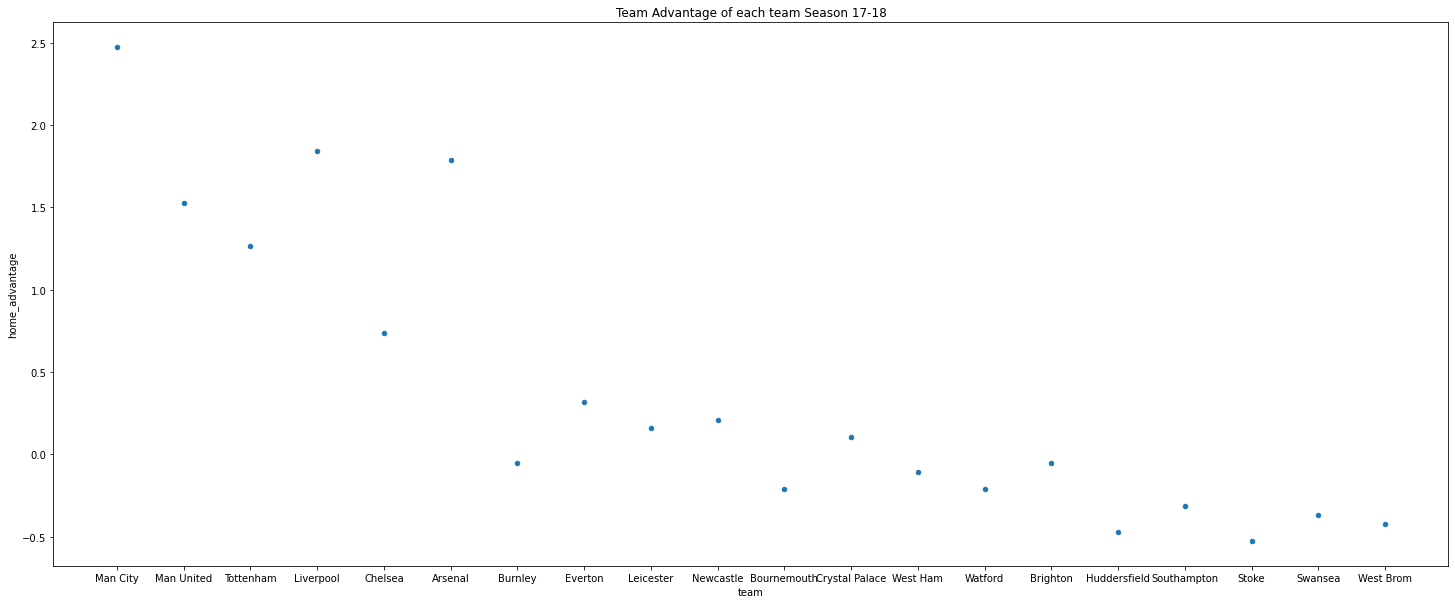

In [21]:
epl_points1718.plot(x='team', y='home_advantage', kind='scatter', 
                    title = 'Team Advantage of each team Season 17-18',
               figsize=(25,10))

<AxesSubplot:title={'center':'Home wins over all wins in 17-18'}, xlabel='team', ylabel='home_win%'>

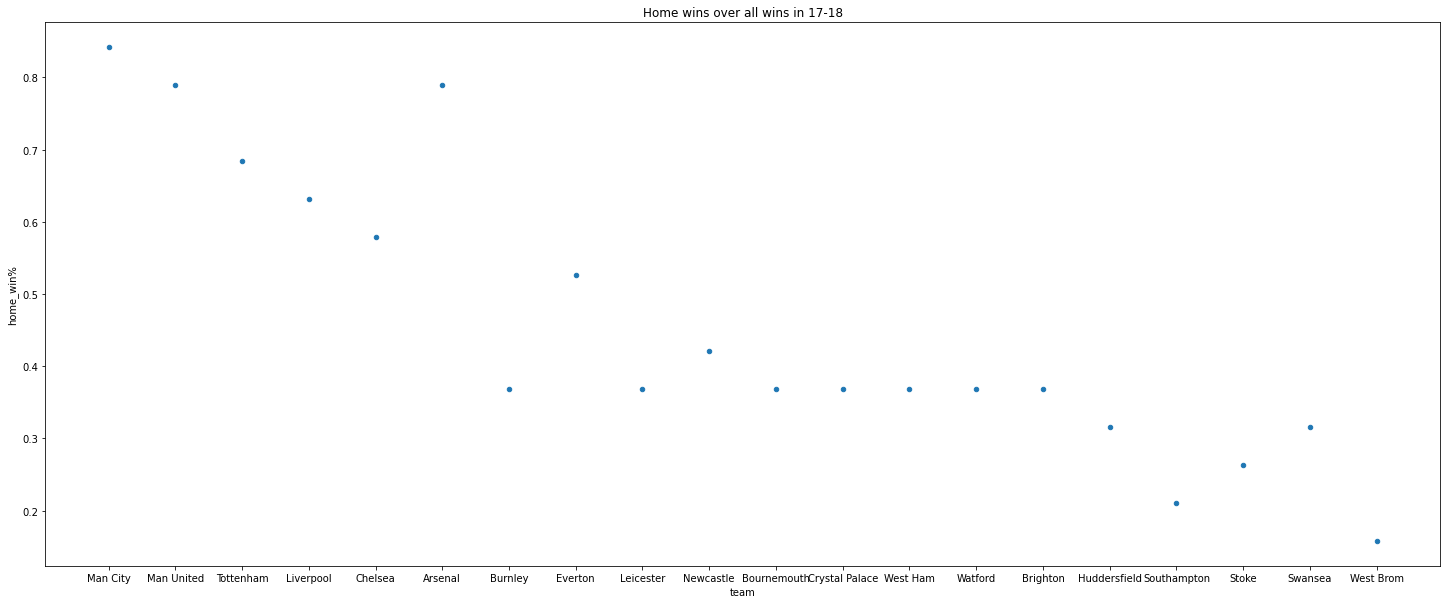

In [22]:
epl_points1718.plot(x='team', y='home_win%', kind='scatter', 
                    title = 'Home wins over all wins in 17-18',
               figsize=(25,10))

### MERGING HOME WINS TABLE AND POINTS TABLE BY TEAM FOR SEASON 17-18 -> ASHRAY 

In [23]:
combined_table1718 = pd.merge(epl_home_games1718,epl_points1718, how='inner', on=['team'])
combined_table1718['year'] = 2017
combined_table1718

,team,matches_played_x,wins_x,loss_x,draw_x,home_win_x,points_x,home_goals_x,home_goals_conceded_x,matches_played_y,...,loss_y,draw_y,home_win_y,points_y,home_goals_y,home_goals_conceded_y,home_win%,total_win%,home_advantage,year
0,Man City,38,32,2,4,16,100,61,14,38,...,2,4,16,100,61,14,0.842105,0.842105,2.473684,2017
1,Arsenal,38,19,13,6,15,63,54,20,38,...,13,6,15,63,54,20,0.789474,0.500000,1.789474,2017
2,Man United,38,25,7,6,15,81,38,9,38,...,7,6,15,81,38,9,0.789474,0.657895,1.526316,2017
3,Tottenham,38,23,7,8,13,77,40,16,38,...,7,8,13,77,40,16,0.684211,0.605263,1.263158,2017
4,Liverpool,38,21,5,12,12,75,45,10,38,...,5,12,12,75,45,10,0.631579,0.552632,1.842105,2017
5,Chelsea,38,21,10,7,11,70,30,16,38,...,10,7,11,70,30,16,0.578947,0.552632,0.736842,2017
6,Everton,38,13,15,10,10,49,28,22,38,...,15,10,10,49,28,22,0.526316,0.342105,0.315789,2017
7,Newcastle,38,12,18,8,8,44,21,17,38,...,18,8,8,44,21,17,0.421053,0.315789,0.210526,2017
8,Watford,38,11,19,8,7,41,27,31,38,...,19,8,7,41,27,31,0.368421,0.289474,-0.210526,2017
9,Burnley,38,14,12,12,7,54,16,17,38,...,12,12,7,54,16,17,0.368421,0.368421,-0.052632,2017


In [24]:
epl_points1617 = epl_table1617.sort_values(by=['points'], ascending=False)

## Insert PL Table 16-17 Image - NAMAN

In [25]:
epl_points1617

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
0,Chelsea,38,30,5,3,17,93,55,17
7,Tottenham,38,26,4,8,17,86,47,9
19,Man City,38,23,6,9,11,78,37,17
10,Liverpool,38,22,6,10,12,76,45,18
2,Arsenal,38,23,9,6,14,75,39,16
5,Man United,38,18,5,15,8,69,26,12
14,Everton,38,17,11,10,13,61,42,16
13,Southampton,38,12,16,10,6,46,17,21
1,Bournemouth,38,12,16,10,9,46,35,29
17,West Brom,38,12,17,9,9,45,27,22


In [26]:
epl_home_games1617 = epl_table1617.sort_values(by=['home_win'], ascending=False)

In [27]:
epl_home_games1617

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
0,Chelsea,38,30,5,3,17,93,55,17
7,Tottenham,38,26,4,8,17,86,47,9
2,Arsenal,38,23,9,6,14,75,39,16
14,Everton,38,17,11,10,13,61,42,16
10,Liverpool,38,22,6,10,12,76,45,18
19,Man City,38,23,6,9,11,78,37,17
8,Burnley,38,11,20,7,10,40,26,20
3,Leicester,38,12,18,8,10,44,31,25
1,Bournemouth,38,12,16,10,9,46,35,29
17,West Brom,38,12,17,9,9,45,27,22


In [28]:
epl_points1617['home_win%'] = epl_points1617['home_win']/19
epl_points1617['total_win%'] = epl_points1617['wins']/epl_points1617['matches_played']
epl_points1617

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
0,Chelsea,38,30,5,3,17,93,55,17,0.894737,0.789474
7,Tottenham,38,26,4,8,17,86,47,9,0.894737,0.684211
19,Man City,38,23,6,9,11,78,37,17,0.578947,0.605263
10,Liverpool,38,22,6,10,12,76,45,18,0.631579,0.578947
2,Arsenal,38,23,9,6,14,75,39,16,0.736842,0.605263
5,Man United,38,18,5,15,8,69,26,12,0.421053,0.473684
14,Everton,38,17,11,10,13,61,42,16,0.684211,0.447368
13,Southampton,38,12,16,10,6,46,17,21,0.315789,0.315789
1,Bournemouth,38,12,16,10,9,46,35,29,0.473684,0.315789
17,West Brom,38,12,17,9,9,45,27,22,0.473684,0.315789


In [29]:
epl_points1617['home_advantage'] = (epl_points1617['home_goals'] - epl_points1617['home_goals_conceded']) /19
epl_points1617

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
0,Chelsea,38,30,5,3,17,93,55,17,0.894737,0.789474,2.000000
7,Tottenham,38,26,4,8,17,86,47,9,0.894737,0.684211,2.000000
19,Man City,38,23,6,9,11,78,37,17,0.578947,0.605263,1.052632
10,Liverpool,38,22,6,10,12,76,45,18,0.631579,0.578947,1.421053
2,Arsenal,38,23,9,6,14,75,39,16,0.736842,0.605263,1.210526
5,Man United,38,18,5,15,8,69,26,12,0.421053,0.473684,0.736842
14,Everton,38,17,11,10,13,61,42,16,0.684211,0.447368,1.368421
13,Southampton,38,12,16,10,6,46,17,21,0.315789,0.315789,-0.210526
1,Bournemouth,38,12,16,10,9,46,35,29,0.473684,0.315789,0.315789
17,West Brom,38,12,17,9,9,45,27,22,0.473684,0.315789,0.263158


<AxesSubplot:title={'center':'Team Advantage of each team Season 16-17'}, xlabel='team', ylabel='home_advantage'>

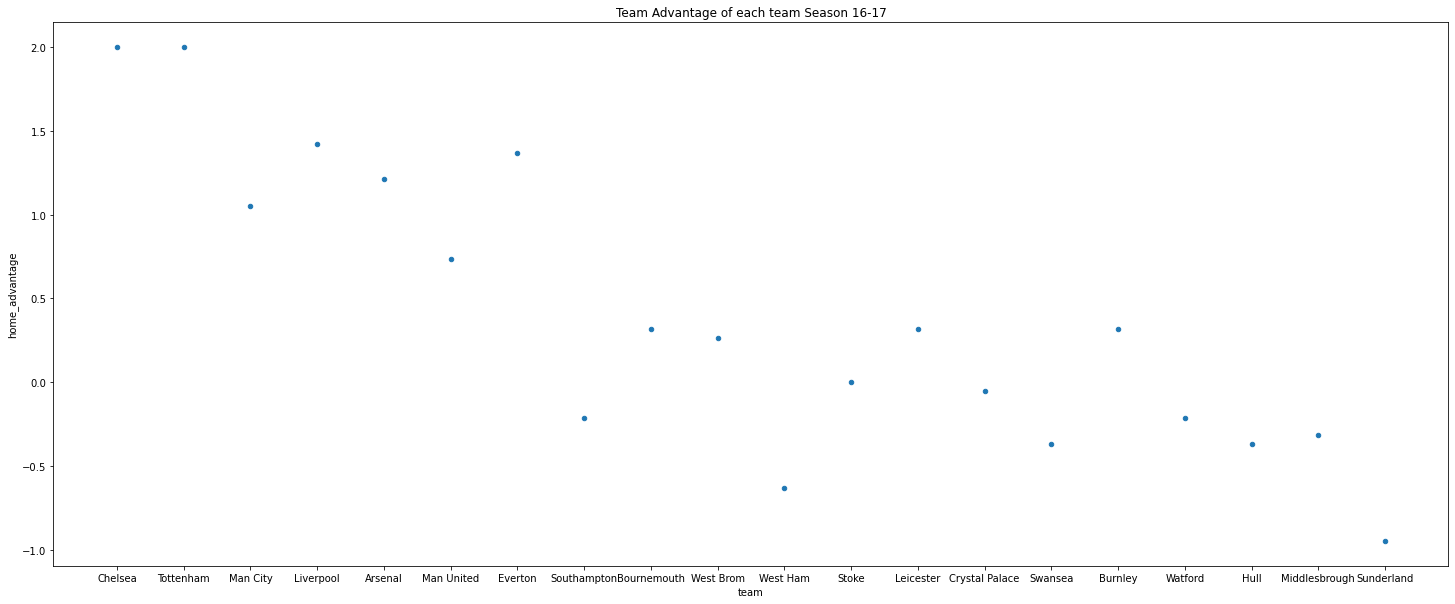

In [30]:
epl_points1617.plot(x='team', y='home_advantage', kind='scatter', 
                    title = 'Team Advantage of each team Season 16-17',
               figsize=(25,10))

<AxesSubplot:title={'center':'Home wins over all wins in 16-17'}, xlabel='team', ylabel='home_win%'>

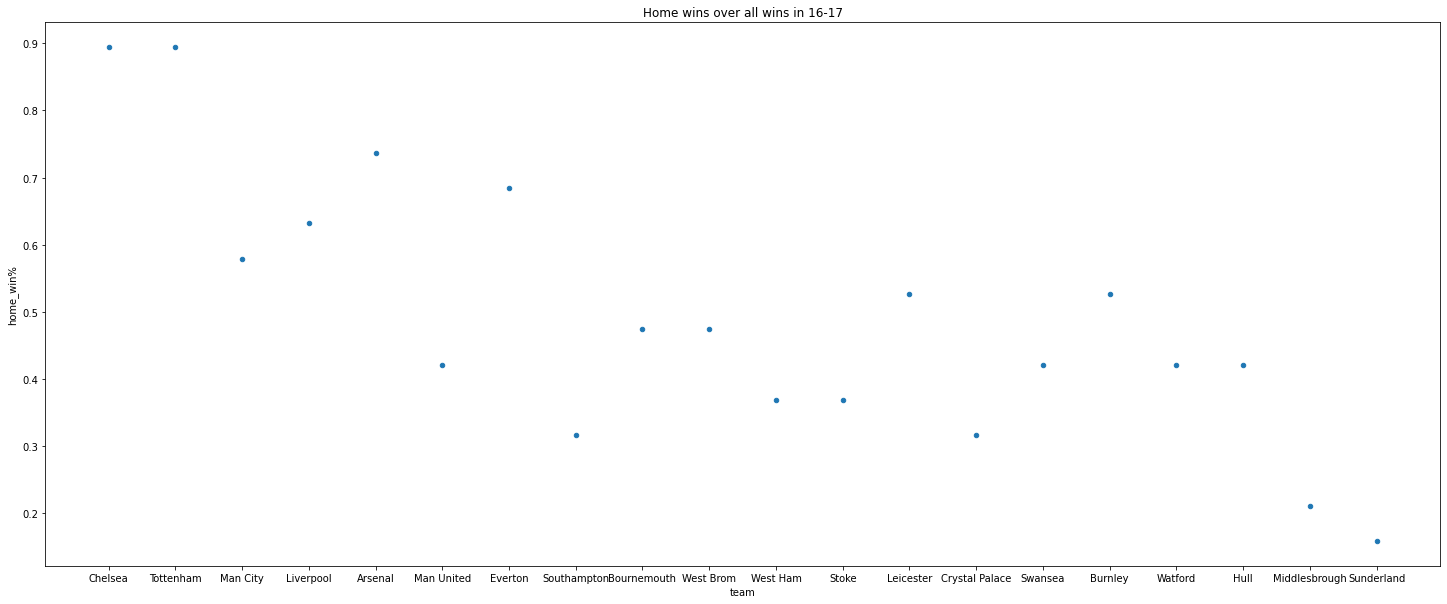

In [31]:
epl_points1617.plot(x='team', y='home_win%', kind='scatter', 
                    title = 'Home wins over all wins in 16-17',
               figsize=(25,10))

### MERGING HOME WINS TABLE AND POINTS TABLE BY TEAM FOR SEASON 16-17 -> ASHRAY 

In [32]:
combined_table1617 = pd.merge(epl_home_games1617,epl_points1617, how='inner', on=['team'])
combined_table1617['year'] = 2016
combined_table1617

,team,matches_played_x,wins_x,loss_x,draw_x,home_win_x,points_x,home_goals_x,home_goals_conceded_x,matches_played_y,...,loss_y,draw_y,home_win_y,points_y,home_goals_y,home_goals_conceded_y,home_win%,total_win%,home_advantage,year
0,Chelsea,38,30,5,3,17,93,55,17,38,...,5,3,17,93,55,17,0.894737,0.789474,2.000000,2016
1,Tottenham,38,26,4,8,17,86,47,9,38,...,4,8,17,86,47,9,0.894737,0.684211,2.000000,2016
2,Arsenal,38,23,9,6,14,75,39,16,38,...,9,6,14,75,39,16,0.736842,0.605263,1.210526,2016
3,Everton,38,17,11,10,13,61,42,16,38,...,11,10,13,61,42,16,0.684211,0.447368,1.368421,2016
4,Liverpool,38,22,6,10,12,76,45,18,38,...,6,10,12,76,45,18,0.631579,0.578947,1.421053,2016
5,Man City,38,23,6,9,11,78,37,17,38,...,6,9,11,78,37,17,0.578947,0.605263,1.052632,2016
6,Burnley,38,11,20,7,10,40,26,20,38,...,20,7,10,40,26,20,0.526316,0.289474,0.315789,2016
7,Leicester,38,12,18,8,10,44,31,25,38,...,18,8,10,44,31,25,0.526316,0.315789,0.315789,2016
8,Bournemouth,38,12,16,10,9,46,35,29,38,...,16,10,9,46,35,29,0.473684,0.315789,0.315789,2016
9,West Brom,38,12,17,9,9,45,27,22,38,...,17,9,9,45,27,22,0.473684,0.315789,0.263158,2016


In [33]:
epl_points1516 = epl_table1516.sort_values(by=['points'], ascending=False)

## Insert PL Table 15-16 Image - Naman

In [34]:
epl_points1516

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
3,Leicester,38,23,3,12,12,81,35,18
2,Arsenal,38,20,7,11,12,71,31,11
7,Tottenham,38,19,6,13,10,70,35,15
19,Man City,38,19,10,9,12,66,47,21
4,Man United,38,19,10,9,12,66,27,9
11,Southampton,38,18,11,9,11,63,39,22
15,West Ham,38,16,8,14,9,62,34,26
8,Liverpool,38,16,10,12,8,60,33,22
14,Stoke,38,14,15,9,8,51,22,24
0,Chelsea,38,12,12,14,5,50,32,30


In [35]:
epl_home_games1516 = epl_table1516.sort_values(by=['home_win'], ascending=False)

In [36]:
epl_home_games1516

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
19,Man City,38,19,10,9,12,66,47,21
2,Arsenal,38,20,7,11,12,71,31,11
3,Leicester,38,23,3,12,12,81,35,18
4,Man United,38,19,10,9,12,66,27,9
11,Southampton,38,18,11,9,11,63,39,22
7,Tottenham,38,19,6,13,10,70,35,15
15,West Ham,38,16,8,14,9,62,34,26
14,Stoke,38,14,15,9,8,51,22,24
8,Liverpool,38,16,10,12,8,60,33,22
9,Swansea,38,12,15,11,8,47,20,20


In [37]:
epl_points1516['home_win%'] = epl_points1516['home_win']/19
epl_points1516['total_win%'] = epl_points1516['wins']/epl_points1516['matches_played']
epl_points1516

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
3,Leicester,38,23,3,12,12,81,35,18,0.631579,0.605263
2,Arsenal,38,20,7,11,12,71,31,11,0.631579,0.526316
7,Tottenham,38,19,6,13,10,70,35,15,0.526316,0.500000
19,Man City,38,19,10,9,12,66,47,21,0.631579,0.500000
4,Man United,38,19,10,9,12,66,27,9,0.631579,0.500000
11,Southampton,38,18,11,9,11,63,39,22,0.578947,0.473684
15,West Ham,38,16,8,14,9,62,34,26,0.473684,0.421053
8,Liverpool,38,16,10,12,8,60,33,22,0.421053,0.421053
14,Stoke,38,14,15,9,8,51,22,24,0.421053,0.368421
0,Chelsea,38,12,12,14,5,50,32,30,0.263158,0.315789


In [38]:
epl_points1516['home_advantage'] = (epl_points1516['home_goals'] - epl_points1516['home_goals_conceded']) /19
epl_points1516

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
3,Leicester,38,23,3,12,12,81,35,18,0.631579,0.605263,0.894737
2,Arsenal,38,20,7,11,12,71,31,11,0.631579,0.526316,1.052632
7,Tottenham,38,19,6,13,10,70,35,15,0.526316,0.500000,1.052632
19,Man City,38,19,10,9,12,66,47,21,0.631579,0.500000,1.368421
4,Man United,38,19,10,9,12,66,27,9,0.631579,0.500000,0.947368
11,Southampton,38,18,11,9,11,63,39,22,0.578947,0.473684,0.894737
15,West Ham,38,16,8,14,9,62,34,26,0.473684,0.421053,0.421053
8,Liverpool,38,16,10,12,8,60,33,22,0.421053,0.421053,0.578947
14,Stoke,38,14,15,9,8,51,22,24,0.421053,0.368421,-0.105263
0,Chelsea,38,12,12,14,5,50,32,30,0.263158,0.315789,0.105263


<AxesSubplot:title={'center':'Team Advantage of each team Season 15-16'}, xlabel='team', ylabel='home_advantage'>

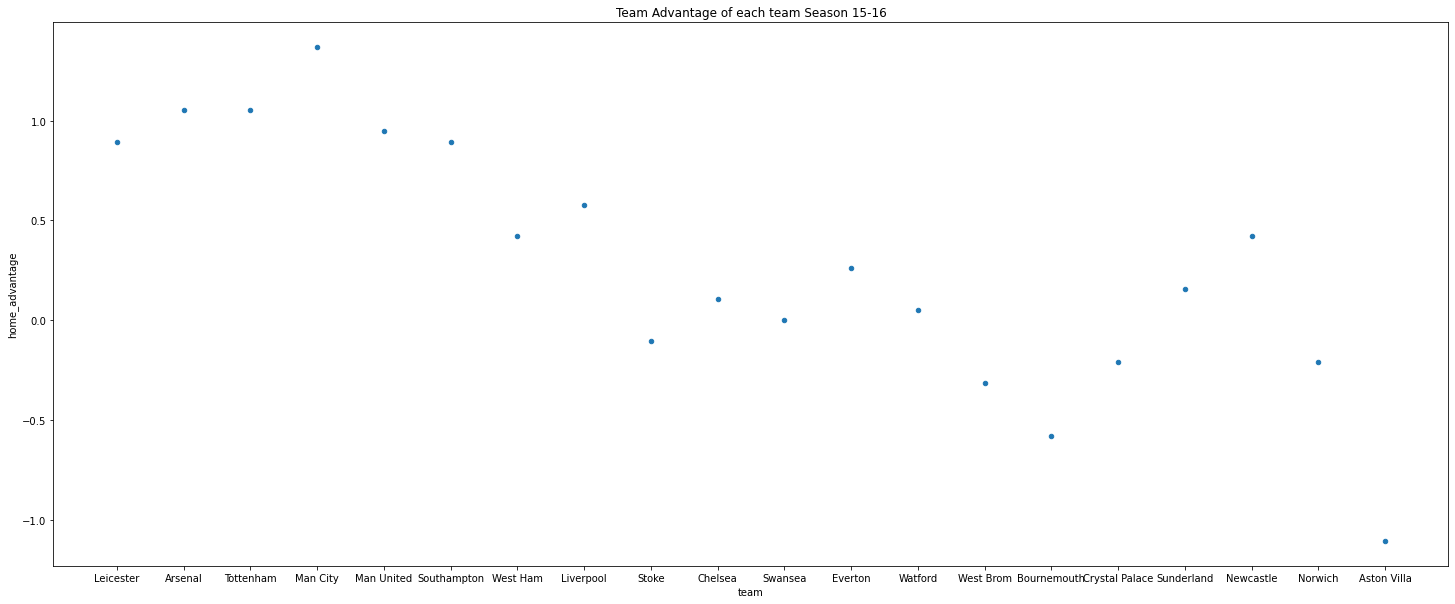

In [39]:
epl_points1516.plot(x='team', y='home_advantage', kind='scatter', 
                    title = 'Team Advantage of each team Season 15-16',
               figsize=(25,10))

<AxesSubplot:title={'center':'Home wins over all wins in 15-16'}, xlabel='team', ylabel='home_win%'>

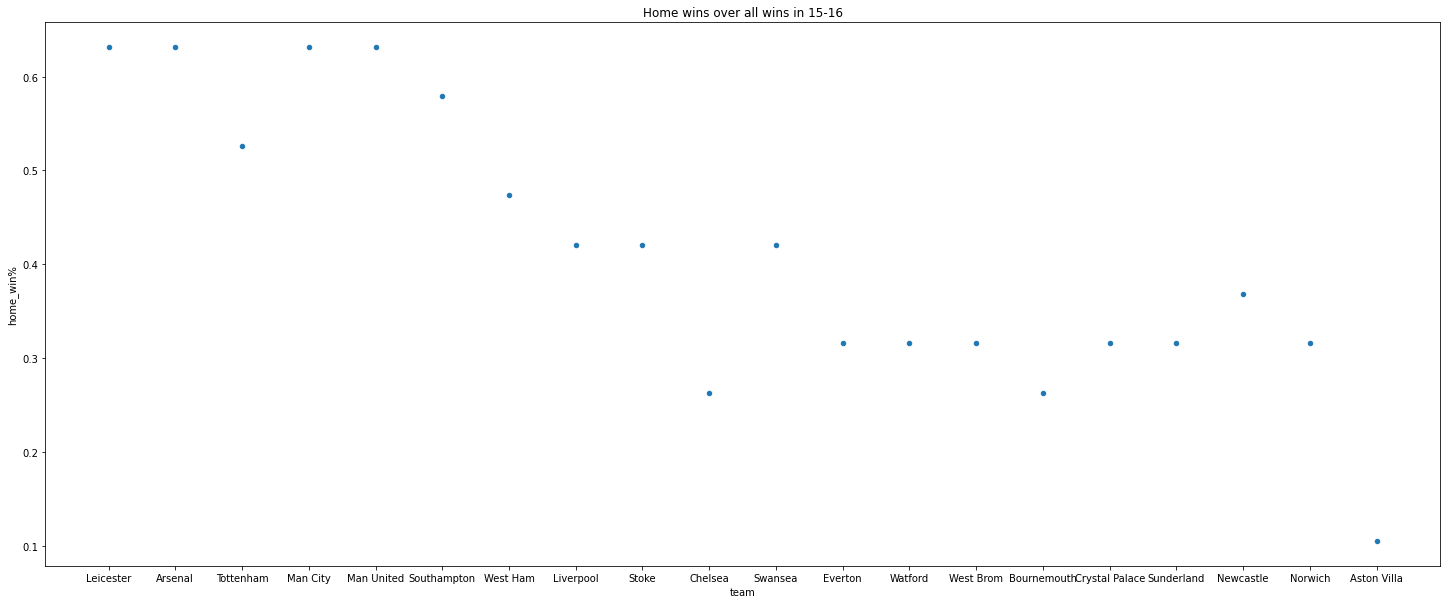

In [40]:
epl_points1516.plot(x='team', y='home_win%', kind='scatter', 
                    title = 'Home wins over all wins in 15-16',
               figsize=(25,10))

### MERGING HOME WINS TABLE AND POINTS TABLE BY TEAM FOR SEASON 15-16 -> ASHRAY 

In [41]:
combined_table1516 = pd.merge(epl_home_games1516,epl_points1516, how='inner', on=['team'])
combined_table1516['year'] = 2015
combined_table1516

,team,matches_played_x,wins_x,loss_x,draw_x,home_win_x,points_x,home_goals_x,home_goals_conceded_x,matches_played_y,...,loss_y,draw_y,home_win_y,points_y,home_goals_y,home_goals_conceded_y,home_win%,total_win%,home_advantage,year
0,Man City,38,19,10,9,12,66,47,21,38,...,10,9,12,66,47,21,0.631579,0.500000,1.368421,2015
1,Arsenal,38,20,7,11,12,71,31,11,38,...,7,11,12,71,31,11,0.631579,0.526316,1.052632,2015
2,Leicester,38,23,3,12,12,81,35,18,38,...,3,12,12,81,35,18,0.631579,0.605263,0.894737,2015
3,Man United,38,19,10,9,12,66,27,9,38,...,10,9,12,66,27,9,0.631579,0.500000,0.947368,2015
4,Southampton,38,18,11,9,11,63,39,22,38,...,11,9,11,63,39,22,0.578947,0.473684,0.894737,2015
5,Tottenham,38,19,6,13,10,70,35,15,38,...,6,13,10,70,35,15,0.526316,0.500000,1.052632,2015
6,West Ham,38,16,8,14,9,62,34,26,38,...,8,14,9,62,34,26,0.473684,0.421053,0.421053,2015
7,Stoke,38,14,15,9,8,51,22,24,38,...,15,9,8,51,22,24,0.421053,0.368421,-0.105263,2015
8,Liverpool,38,16,10,12,8,60,33,22,38,...,10,12,8,60,33,22,0.421053,0.421053,0.578947,2015
9,Swansea,38,12,15,11,8,47,20,20,38,...,15,11,8,47,20,20,0.421053,0.315789,0.000000,2015


In [42]:
epl_points1415 = epl_table1415.sort_values(by=['points'], ascending=False)

## Insert PL Table Image 14-15

In [43]:
epl_points1415

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
0,Chelsea,38,26,3,9,15,87,36,9
19,Man City,38,24,7,7,14,79,44,14
1,Arsenal,38,22,7,9,12,75,41,14
3,Man United,38,20,8,10,14,70,41,15
6,Tottenham,38,19,12,7,10,64,31,24
9,Liverpool,38,18,12,8,10,62,30,20
12,Southampton,38,18,14,6,11,60,37,13
10,Swansea,38,16,14,8,9,56,27,22
14,Stoke,38,15,14,9,10,54,32,22
11,Crystal Palace,38,13,16,9,6,48,21,27


In [44]:
epl_home_games1415 = epl_table1415.sort_values(by=['home_win'], ascending=False)

In [45]:
epl_home_games1415

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
0,Chelsea,38,26,3,9,15,87,36,9
3,Man United,38,20,8,10,14,70,41,15
19,Man City,38,24,7,7,14,79,44,14
1,Arsenal,38,22,7,9,12,75,41,14
12,Southampton,38,18,14,6,11,60,37,13
6,Tottenham,38,19,12,7,10,64,31,24
14,Stoke,38,15,14,9,10,54,32,22
9,Liverpool,38,18,12,8,10,62,30,20
10,Swansea,38,16,14,8,9,56,27,22
15,West Ham,38,12,15,11,9,47,25,18


In [46]:
epl_points1415['home_win%'] = epl_points1415['home_win']/19
epl_points1415['total_win%'] = epl_points1415['wins']/epl_points1516['matches_played']
epl_points1415

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
0,Chelsea,38,26,3,9,15,87,36,9,0.789474,0.684211
19,Man City,38,24,7,7,14,79,44,14,0.736842,0.631579
1,Arsenal,38,22,7,9,12,75,41,14,0.631579,0.578947
3,Man United,38,20,8,10,14,70,41,15,0.736842,0.526316
6,Tottenham,38,19,12,7,10,64,31,24,0.526316,0.500000
9,Liverpool,38,18,12,8,10,62,30,20,0.526316,0.473684
12,Southampton,38,18,14,6,11,60,37,13,0.578947,0.473684
10,Swansea,38,16,14,8,9,56,27,22,0.473684,0.421053
14,Stoke,38,15,14,9,10,54,32,22,0.526316,0.394737
11,Crystal Palace,38,13,16,9,6,48,21,27,0.315789,0.342105


In [47]:
epl_points1415['home_advantage'] = (epl_points1415['home_goals'] - epl_points1415['home_goals_conceded']) /19
epl_points1415

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
0,Chelsea,38,26,3,9,15,87,36,9,0.789474,0.684211,1.421053
19,Man City,38,24,7,7,14,79,44,14,0.736842,0.631579,1.578947
1,Arsenal,38,22,7,9,12,75,41,14,0.631579,0.578947,1.421053
3,Man United,38,20,8,10,14,70,41,15,0.736842,0.526316,1.368421
6,Tottenham,38,19,12,7,10,64,31,24,0.526316,0.500000,0.368421
9,Liverpool,38,18,12,8,10,62,30,20,0.526316,0.473684,0.526316
12,Southampton,38,18,14,6,11,60,37,13,0.578947,0.473684,1.263158
10,Swansea,38,16,14,8,9,56,27,22,0.473684,0.421053,0.263158
14,Stoke,38,15,14,9,10,54,32,22,0.526316,0.394737,0.526316
11,Crystal Palace,38,13,16,9,6,48,21,27,0.315789,0.342105,-0.315789


<AxesSubplot:title={'center':'Team Advantage of each team Season 14-15'}, xlabel='team', ylabel='home_advantage'>

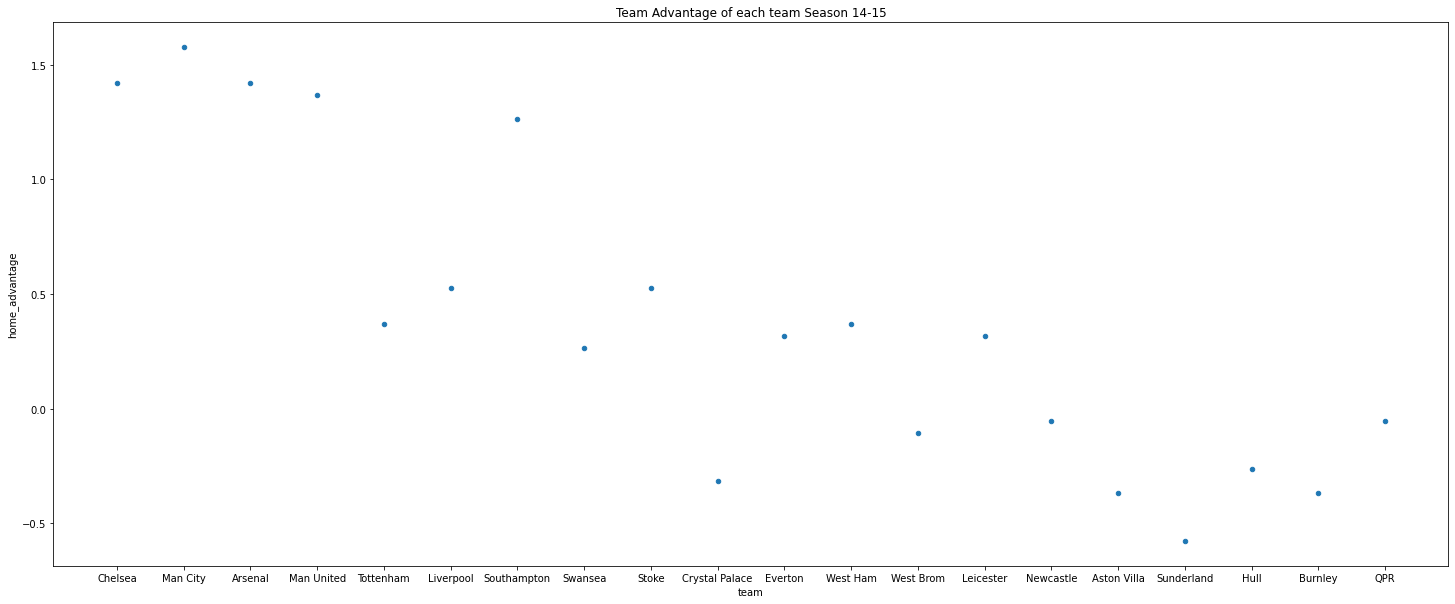

In [48]:
epl_points1415.plot(x='team', y='home_advantage', kind='scatter', 
                    title = 'Team Advantage of each team Season 14-15',
               figsize=(25,10))

<AxesSubplot:title={'center':'Home wins over all wins in 14-15'}, xlabel='team', ylabel='home_win%'>

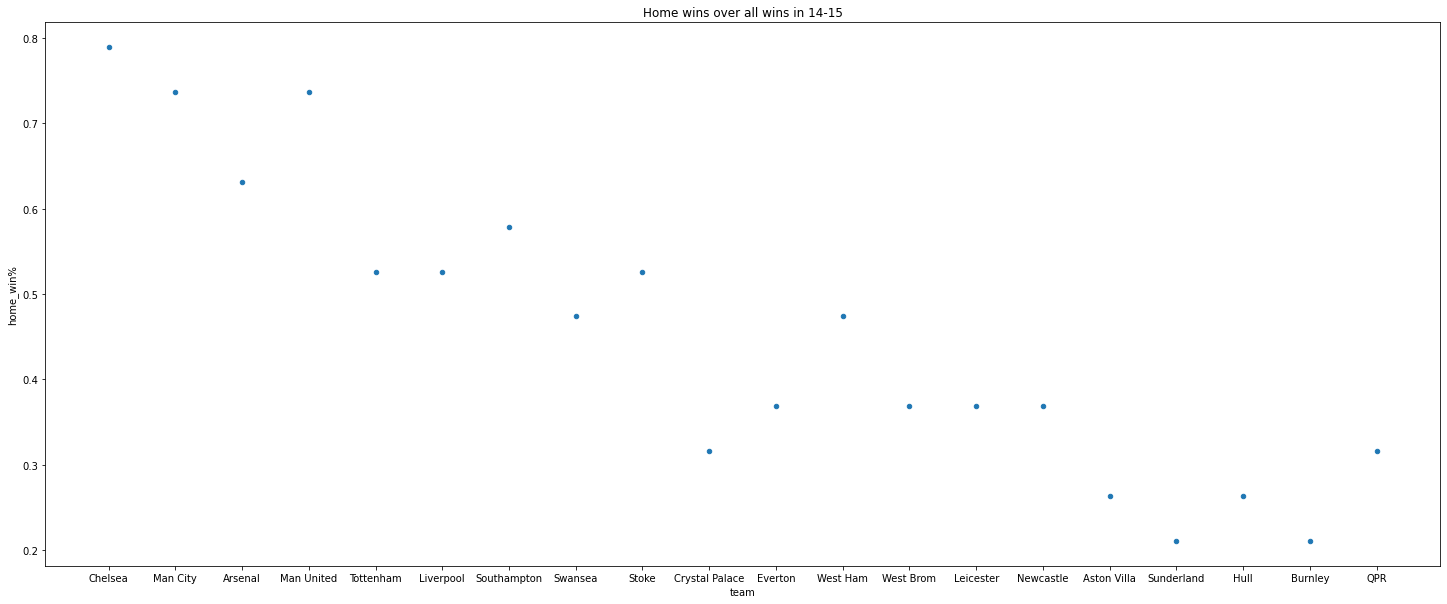

In [49]:
epl_points1415.plot(x='team', y='home_win%', kind='scatter', 
                    title = 'Home wins over all wins in 14-15',
               figsize=(25,10))

### MERGING HOME WINS TABLE AND POINTS TABLE BY TEAM FOR SEASON 14-15 -> ASHRAY 

In [50]:
combined_table1415 = pd.merge(epl_home_games1415,epl_points1415, how='inner', on=['team'])
combined_table1415['year'] = 2014
combined_table1415

,team,matches_played_x,wins_x,loss_x,draw_x,home_win_x,points_x,home_goals_x,home_goals_conceded_x,matches_played_y,...,loss_y,draw_y,home_win_y,points_y,home_goals_y,home_goals_conceded_y,home_win%,total_win%,home_advantage,year
0,Chelsea,38,26,3,9,15,87,36,9,38,...,3,9,15,87,36,9,0.789474,0.684211,1.421053,2014
1,Man United,38,20,8,10,14,70,41,15,38,...,8,10,14,70,41,15,0.736842,0.526316,1.368421,2014
2,Man City,38,24,7,7,14,79,44,14,38,...,7,7,14,79,44,14,0.736842,0.631579,1.578947,2014
3,Arsenal,38,22,7,9,12,75,41,14,38,...,7,9,12,75,41,14,0.631579,0.578947,1.421053,2014
4,Southampton,38,18,14,6,11,60,37,13,38,...,14,6,11,60,37,13,0.578947,0.473684,1.263158,2014
5,Tottenham,38,19,12,7,10,64,31,24,38,...,12,7,10,64,31,24,0.526316,0.500000,0.368421,2014
6,Stoke,38,15,14,9,10,54,32,22,38,...,14,9,10,54,32,22,0.526316,0.394737,0.526316,2014
7,Liverpool,38,18,12,8,10,62,30,20,38,...,12,8,10,62,30,20,0.526316,0.473684,0.526316,2014
8,Swansea,38,16,14,8,9,56,27,22,38,...,14,8,9,56,27,22,0.473684,0.421053,0.263158,2014
9,West Ham,38,12,15,11,9,47,25,18,38,...,15,11,9,47,25,18,0.473684,0.315789,0.368421,2014


In [51]:
# combined_table.plot(x='Year', y='home_advantage', kind='scatter', 
#                     title = 'Team Home Advantages Over Time')